In [146]:
import pandas as pd
import numpy as np
import math
import random
from random import sample 
import time
import scipy.optimize as spo
import matplotlib.pyplot as plt


In [147]:
def test_run(symbols,date):
    
    dates= pd.date_range(date[0],date[1])
    
    #create empty dataframe
    df1 = pd.DataFrame(index=dates)

    for symbol in symbols:
        df_temp=pd.read_csv("data/{}.csv".format(symbol),index_col="Date",
                        parse_dates=True,usecols=['Date','Adj Close'],
                        na_values=['nan'])
        #rename to prevent clash
        df_temp=df_temp.rename(columns={'Adj Close':symbol})
        df1=df1.join(df_temp,how="inner")
    return df1

In [148]:
def compute_daily_returns(df):
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:]/df[:-1].values) -1
    daily_returns.iloc[0]=0
    return daily_returns
def compute_normed(df):
    normed = df.copy()
    normed = df/df.iloc[0,:]
    return normed
def compute_alloc(df,allocs):
    dfalloc = df.copy()
    dfalloc = df*allocs
    return dfalloc
def compute_posval(df,pos_val):
    dfposval = df.copy()
    dfposval = df*pos_val
    return dfposval
def comupte_portval(df):
    dfportval = df.copy()
    dfportval = dfportval.sum(axis=1)
    return dfportval
def compute_sharp_ratio(df):
    rfr = 1.0+0.5
    daily_rf = (rfr**(1/252))-1
    return ((df-daily_rf).mean()/df.std())* (252**(1/2))

In [149]:
def minSratio(allocs,df):
    #Normalized 
    dfnorm = compute_normed(df)
#     allocs=[0.4,0.4,0.1,0.1]
    print(allocs)
    pos_val = 100000
    # Added allocation
    dfalloc = compute_alloc(dfnorm,allocs)
    #Added money
    dfpos_val = compute_posval(dfalloc,pos_val)
    #Add portfolio value
    dfport_val = comupte_portval(dfpos_val)
    # print(dfport_val)
    # Add daily returns
    daily_returns = compute_daily_returns(dfport_val)
    # Average and std of daily returns
    avg_daily_returns = daily_returns.mean()
    std_daily_returns = daily_returns.std()
    # print(avg_daily_returns)
    # Compute Sharpe ratio
    sharp_ratio = compute_sharp_ratio(daily_returns)
    # K* Sharp ratio where  k is frequency of sample u r taking
    print(sharp_ratio)
    return sharp_ratio

In [191]:
symbols=['3MINDIA','HDFCBANK','NESTLEIND','ITC','PIDILITIND','TITAN']
date=["2007-6-11","2020-6-11"]
windows = 20
df = test_run(symbols,date)
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
# print(df)

# df['ad_SMA'], df['momentum'], df['BBU'], df['BBL'] = feature(df,windows)
# df = df.iloc[windows:]
print(df)
print(df.shape)

                 3MINDIA     HDFCBANK     NESTLEIND         ITC   PIDILITIND  \
2007-06-11   1780.099976    76.393013    435.276642   32.989189    52.025238   
2007-06-12   1758.349976    75.562424    435.276642   32.978443    51.961472   
2007-06-13   1722.099976    75.239243    435.276642   32.592609    52.067730   
2007-06-14   1751.349976    76.309624    435.276642   32.496151    51.897713   
2007-06-15   1722.449951    77.028984    435.276642   32.667656    52.067730   
...                  ...          ...           ...         ...          ...   
2020-06-05  17979.199219  1034.750000  17033.726563  200.000000  1508.300049   
2020-06-08  18271.699219  1015.450012  16774.085938  197.649994  1492.300049   
2020-06-09  18166.800781   986.950012  16491.533203  198.500000  1467.300049   
2020-06-10  18260.099609   991.799988  16473.699219  199.050003  1454.750000   
2020-06-11  17578.599609   968.650024  16608.199219  194.250000  1417.300049   

                  TITAN  
2007-06-11   

### Optimizer

[0.3  0.23 0.24 0.3  0.3  0.3 ]
-0.5756937921183891
[0.3  0.23 0.24 0.3  0.3  0.3 ]
-0.5756937921183891
[0.30000001 0.23       0.24       0.3        0.3        0.3       ]
-0.5756937955908135
[0.3        0.23000001 0.24       0.3        0.3        0.3       ]
-0.5756937887984618
[0.3        0.23       0.24000001 0.3        0.3        0.3       ]
-0.5756937875535059
[0.3        0.23       0.24       0.30000001 0.3        0.3       ]
-0.5756937962882616
[0.3        0.23       0.24       0.3        0.30000001 0.3       ]
-0.5756937937474423
[0.3        0.23       0.24       0.3        0.3        0.30000001]
-0.5756937890442241
[0.13       0.17824641 0.24       0.15       0.07       0.23175359]
-0.4342786694794494
[0.13       0.17824641 0.24       0.15       0.07       0.23175359]
-0.4342786694794494
[0.13000001 0.17824641 0.24       0.15       0.07       0.23175359]
-0.4342786756153619
[0.13       0.17824643 0.24       0.15       0.07       0.23175359]
-0.43427866790773056
[0.13       0.1

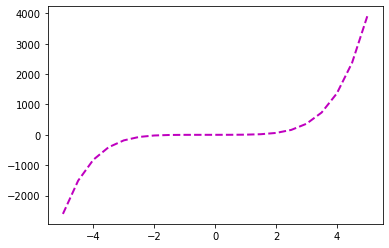

In [206]:
def error_poly(C, data):
#     err = np.sum((data[:,1] - np.polyval(C, data[:, 0])) ** 2)
    err = minSratio(C,data)* -1
    return err

def apply_sum_constraint(inputs):
    #return value must come back as 0 to be accepted
    #if return value is anything other than 0 it's rejected
    #as not a valid answer.
    total = 1 - np.sum(inputs)
    return total

my_constraints = ({'type': 'eq', "fun": apply_sum_constraint })
def fit_poly(data, error_func, degree=3):
    #Generate initial guess for polynomial model (all coeffs = 1)
    Cguess = np.poly1d(np.ones(degree+1, dtype=np.float32))
    bound = [(0.13,0.30),(0.08,0.23),(0.08,0.24),(0.15,0.30),(0.07,0.30),(0.08,0.30)]
    #Plot initial guess (optional)
    x = np.linspace(-5, 5, 21)
    plt.plot(x, np.polyval(Cguess, x), 'm--', linewidth=2.0, label="Initial guess")
    
    #Call optimizer to minimize
    result = spo.minimize(error_func, Cguess, args=(data,), method='SLSQP',
                          bounds=bound,constraints=my_constraints, options={'disp':True})
#     return np.poly1d(result.x)
    return result.x
optAloc = fit_poly(df,error_poly,5)*100
for i in range(6):
    print("Allocate ",str(int(optAloc[i]))+"%","\t in ",symbols[i])

Original line: C0 and C1 =  4.0 2.0
Fitted line: C0 and C1 =  4.205261704414622 1.5003889080986812


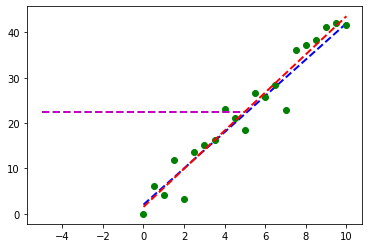

In [196]:
# ['3MINDIA','HDFCBANK','NESTLEIND','ITC','PIDILITIND','TITAN']
def error(line,data):
    err = np.sum((data[:,1] - (line[0] * data[:, 0] + line[1])) ** 2)
    return err

def fit_line(data, error_func):
    
    # Generate initial guess for the line model
    l = np.float32([0, np.mean(data[:, 1])]) # slope=0, intercept = mean( y values)
    
    #plot initial guess for the model
    x_ends = np.float32([-5,5])
    plt.plot(x_ends, l[0] * x_ends + l[1], 'm--', linewidth=2.0, label='Initial guess')
    
    # Call optimizer to minimize errror function
    result = spo.minimize(error_func, l, args=(data,), method='SLSQP', options=None)
    return result.x

def optimizer_run():
    # Define original line
    l_orig = np.float32([4,2])
    print("Original line: C0 and C1 = ",l_orig[0],l_orig[1])
    Xorig = np.linspace(0, 10, 21)
    Yorig = l_orig[0] * Xorig + l_orig[1]
    plt.plot(Xorig, Yorig, 'b--', linewidth=2.0, label="Original line")
    
    # Generate noisy data points
    noise_sigma = 3.0
    noise = np.random.normal(0, noise_sigma, Yorig.shape)
    data = np.asarray([Xorig, Yorig + noise]).T
    plt.plot(data[:,0], data[:, 1], 'go', label = "Data points")
    
    #Try to fit a line in this data
    l_fit = fit_line(data, error)
    print("Fitted line: C0 and C1 = ", l_fit[0],l_fit[1])
    plt.plot(data[:,0], l_fit[0] * data[:, 0] + l_fit[1], 'r--', linewidth=2.0, label = "Fitted line")

optimizer_run()